In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

sc.settings.verbosity = 3
sc.set_figure_params(figsize=(8.5, 8), dpi=150)

# load adata

In [2]:
adata2 = sc.read_h5ad('../../processed_data/CDSDB_mdmt_613.h5ad')
adata2

AnnData object with n_obs × n_vars = 613 × 978
    obs: 'Sample ID', 'Base/Post', 'CDS-DB patient signature list', 'CDS-DB dataset list', 'Patient ID', 'Sampling location', 'Sampling time', 'Annotation of the therapeutic regimen from the data source', 'Therapeutic Regimen Recorded In The Data Source', 'Therapeutic regimen', 'Therapeutic regimen ID', 'Administration dose', 'Additional information about the therapeutic regimen', 'Drug category', 'Source dataset', 'Source database', 'Reference (PubMed ID)', 'Data type', 'Platform', 'Cancer subtype recorded in the data source', 'Cancer subtype', 'DOID of cancer subtype', 'Sampling location category', 'Additional information about the cancer', 'Original response status', 'Response group', 'Pediatric oncology', 'Predefined grouping criteria of response and non-response groups', 'Drug category_compact', 'sample_id_unique', 'pair_match_id', 'pert_time', 'pert_time_idx', 'pert_dose', 'pert_dose_unit', 'pert_dose_idx', 'pert_id', 'pert_idx', 'ti

In [3]:
adata2_breast = adata2[(adata2.obs["split_breast_GSE20181"] != 0)]
adata2_breast_deg = sc.AnnData(X=adata2_breast.X-adata2_breast.obsm["X_ctl"], obs=adata2_breast.obs,
                                     var = adata2_breast.var,
                                     uns=adata2_breast.uns)

adata2_breast.n_obs

114

In [4]:
adata2_breast.obs.pert_id.unique()

['Letrozole']
Categories (1, object): ['Letrozole']

### Obtain attention score

Due to the large size of the attention file, it is not provided. Please refer to the following code to obtain the attention scores for the samples to be analyzed.
```
python train_xpert.py --model XPert --config config_cdsdb --drug_feat unimol --dataset cdsdb_mdmt --use_gradscaler True\
--include_cell_idx True --mode infer\
--nfold split_breast_GSE20181\
--saved_model "saved_model/cdsdb_warm_split.pth"\
--output_attention True
```

In [ ]:
attenion_file_path = " "
with open(attenion_file_path, "rb") as f:
    attention_dict = pickle.load(f)

attention_dict_trt = attention_dict["trt"]
attention_dict_ctl = attention_dict["ctl"]
attention_dict_trt.keys(), attention_dict_ctl.keys()

### Obtain the attention scores from the cls token to each gene for all samples.

In [ ]:
trt_attention_dict = { k:attention_dict_trt[k].mean(axis=1).mean(axis=1)[:, 1:] for k in attention_dict_trt.keys()}
ctl_attention_dict = { k:attention_dict_ctl[k].mean(axis=1).mean(axis=1)[:, 1:] for k in attention_dict_ctl.keys()}
ctl_attention_dict["SA_0"].shape

In [10]:
adata2_breast_ctl_attn = sc.AnnData(X= (ctl_attention_dict["SA_1"]+ctl_attention_dict["SA_2"]+ctl_attention_dict["SA_0"]+ctl_attention_dict["SA_3"])/4, 
                                obs=adata2_breast.obs,
                                var = adata2_breast.var,
                                uns=adata2_breast.uns)
adata2_breast_ctl_attn = adata2_breast_ctl_attn[adata2_breast_ctl_attn.obs['Response group']!="unknown"]

adata2_breast_ctl_attn

View of AnnData object with n_obs × n_vars = 102 × 978
    obs: 'Sample ID', 'Base/Post', 'CDS-DB patient signature list', 'CDS-DB dataset list', 'Patient ID', 'Sampling location', 'Sampling time', 'Annotation of the therapeutic regimen from the data source', 'Therapeutic Regimen Recorded In The Data Source', 'Therapeutic regimen', 'Therapeutic regimen ID', 'Administration dose', 'Additional information about the therapeutic regimen', 'Drug category', 'Source dataset', 'Source database', 'Reference (PubMed ID)', 'Data type', 'Platform', 'Cancer subtype recorded in the data source', 'Cancer subtype', 'DOID of cancer subtype', 'Sampling location category', 'Additional information about the cancer', 'Original response status', 'Response group', 'Pediatric oncology', 'Predefined grouping criteria of response and non-response groups', 'Drug category_compact', 'sample_id_unique', 'pair_match_id', 'pert_time', 'pert_time_idx', 'pert_dose', 'pert_dose_unit', 'pert_dose_idx', 'pert_id', 'pert_i

# ctl-attn: non-response v.s. response

In [20]:
from scipy import stats
from adjustText import adjust_text
from statsmodels.stats.multitest import multipletests

def generate_df(adata):
    
    adata = adata[adata.obs["Response group"]!='unknown']
    adata = adata[adata.obs.sort_values(by='Response group', ascending=False).index,:]
    
    response_group_statics = dict(adata.obs["Response group"].value_counts())
    response_num = response_group_statics["Response"]
    
    df = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs["Response group"])
    
    # The raw attention score values are too small (softmax was applied over 978 samples), which leads to floating-point precision issues when performing t-tests,
    # so we first multiply them by a constant of 1000.
    df = df*1000

    df['NON/RES'] = np.mean(df.values[:,response_num:],1)/np.mean(df.values[:,:response_num],1)
    df['P-value'] = [stats.ttest_ind(a,b)[1] for a,b in zip(df.values[:,response_num:], df.values[:,:response_num])]
    
    
    return df

In [21]:
pd_df = generate_df(adata2_breast_ctl_attn)
pd_df.head()

Response group,Response,Response,Response,Response,Response,Response,Response,Response,Response,Response,...,Non-response,Non-response,Non-response,Non-response,Non-response,Non-response,Non-response,Non-response,NON/RES,P-value
gene_symbol,,,,,,,,,,,,,,,,,,,,,
DDR1,1.265805,1.499800,1.265805,0.756933,0.862415,1.282310,1.099477,0.811815,1.204567,1.297078,...,1.031206,1.043882,1.260359,1.260359,1.784818,0.827066,1.342535,0.743442,0.986763,0.824181
PAX8,0.409428,0.690776,0.409428,0.531035,1.484857,1.347884,0.444171,0.527402,0.610960,0.641527,...,3.402737,0.629049,0.676521,0.676521,0.466744,0.512954,0.425910,1.530192,1.315821,0.047854
RPS5,0.715027,3.810697,0.715027,1.377731,1.220234,0.844741,0.977581,0.764582,0.858566,0.636667,...,1.043675,2.163560,0.724316,0.724316,0.844479,0.998026,0.760570,0.927227,0.716482,0.092071
ABCF1,0.729691,1.389229,0.729691,1.294118,0.615801,1.147644,1.074613,0.559702,0.597776,1.181893,...,0.539921,0.608735,0.644225,0.644225,0.470004,0.665594,0.620011,1.032995,0.802967,0.002637
SPAG7,0.771827,0.627744,0.771827,0.814960,0.528195,0.565576,0.508662,0.483097,0.655906,0.661689,...,0.723376,0.601409,0.574733,0.574733,1.672366,0.588854,0.780652,0.839676,1.169084,0.026110


                    x         y    group
gene_symbol                             
DDR1        -0.019225  0.278968  #C3C1C0
PAX8         0.395963  4.385229     grey
RPS5        -0.480998  3.441105  #C3C1C0
ABCF1       -0.316588  8.566829     grey
SPAG7        0.225379  5.259229     grey


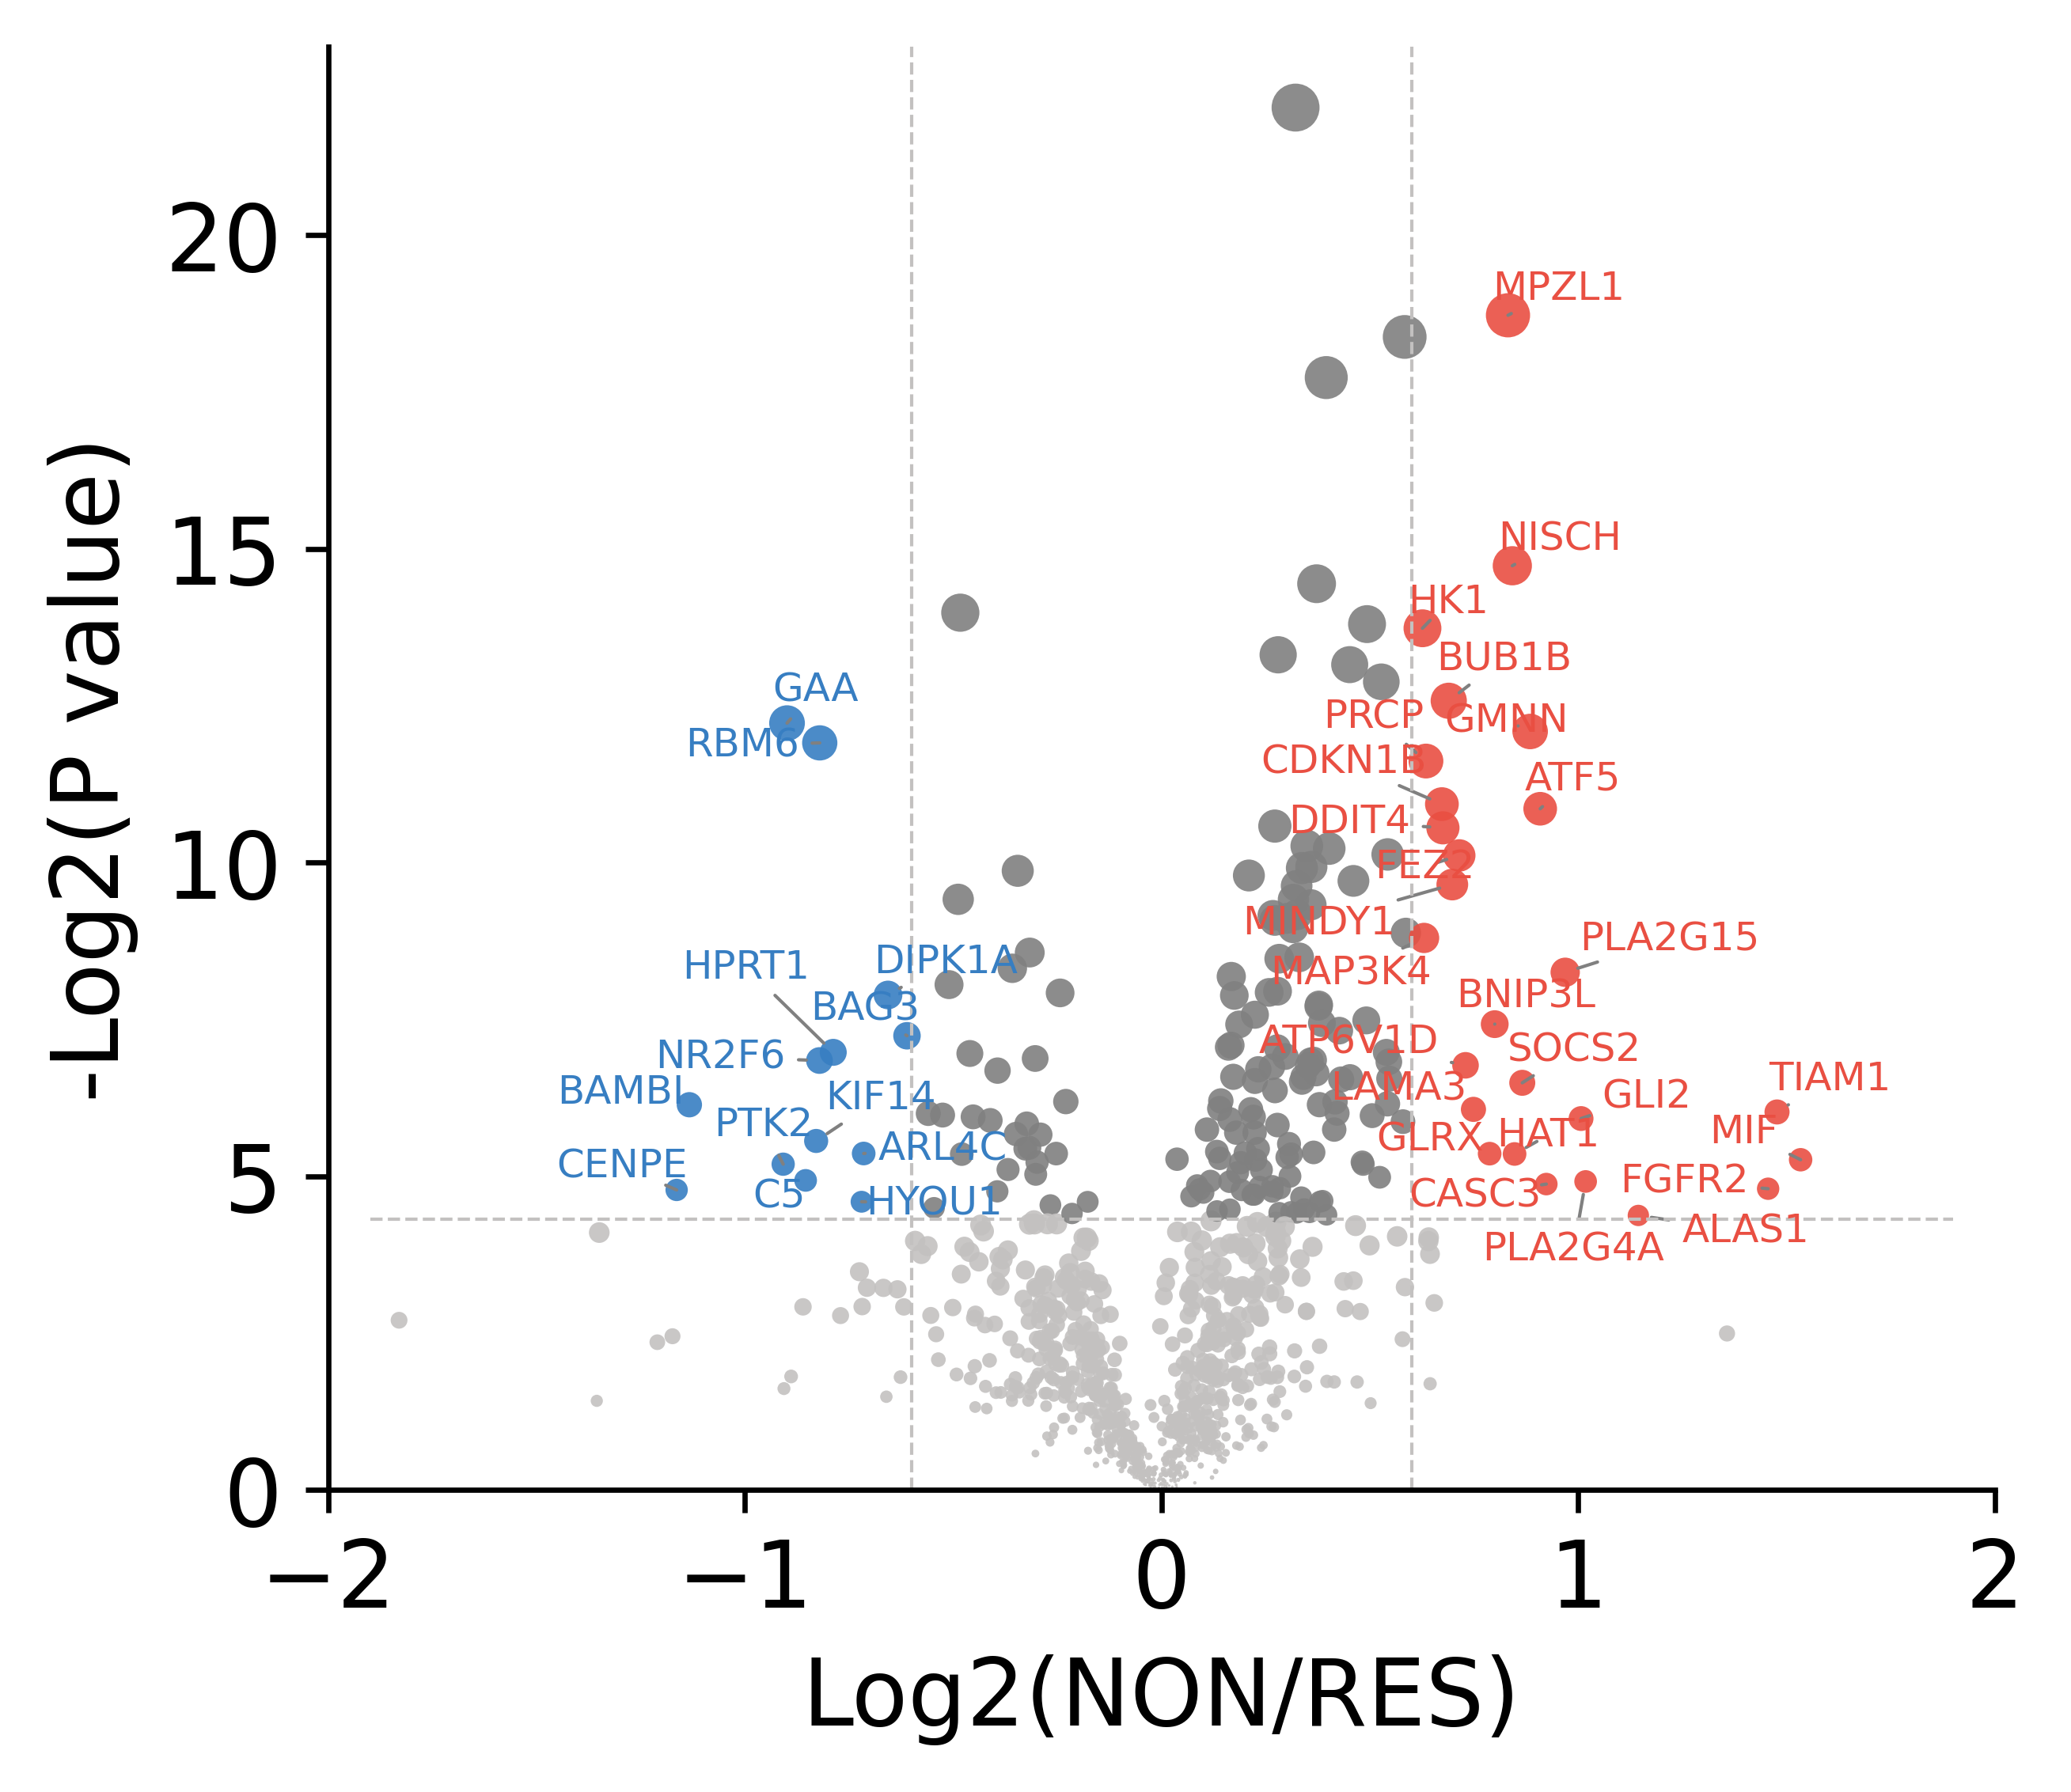

In [22]:
result = pd.DataFrame()
result['x'] = np.log2(pd_df['NON/RES'])
result['y'] = -np.log2(pd_df['P-value'])

x_threshold= 0.6 
y_threshold= -np.log2(0.05)

result['group'] = 'grey'
result.loc[(result.x > x_threshold)&(result.y > y_threshold),'group'] = '#E94F42'
result.loc[(result.x < -x_threshold)&(result.y > y_threshold),'group'] = '#377EC2'
result.loc[result.y < y_threshold,'group'] = '#C3C1C0'
print(result.head())

xmin=-2
xmax=2
ymin=0
ymax=23

fig = plt.figure(dpi=300,figsize=(4.5, 4))
ax = fig.add_subplot()
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), title='')
ax.scatter(result['x'], result['y'], s=result['y']*2.4, c=result['group'], alpha=0.9, linewidths=0)
ax.set_ylabel('-Log2(P value)')
ax.set_xlabel('Log2(NON/RES)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.vlines(-x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.vlines(x_threshold, ymin, ymax, color='#C3C1C0',linestyle='dashed', linewidth=0.5)
ax.hlines(y_threshold, xmin+0.1, xmax-0.1, color='#C3C1C0',linestyle='dashed', linewidth=0.5)

texts = []
for i, row in result.iterrows():
    if row['group'] != 'grey' and row['group'] != '#C3C1C0':
        text = ax.text(row['x'], row['y'], str(i), fontsize=6, ha='right', va='bottom', color=row['group'])
        texts.append(text)

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.grid(False)

plt.show()

# fig.savefig('figs/volcano_attention_ctl_non&res.svg',dpi=600,format='svg', bbox_inches='tight')

# distribution of average ddifferential expression：non-response v.s. response

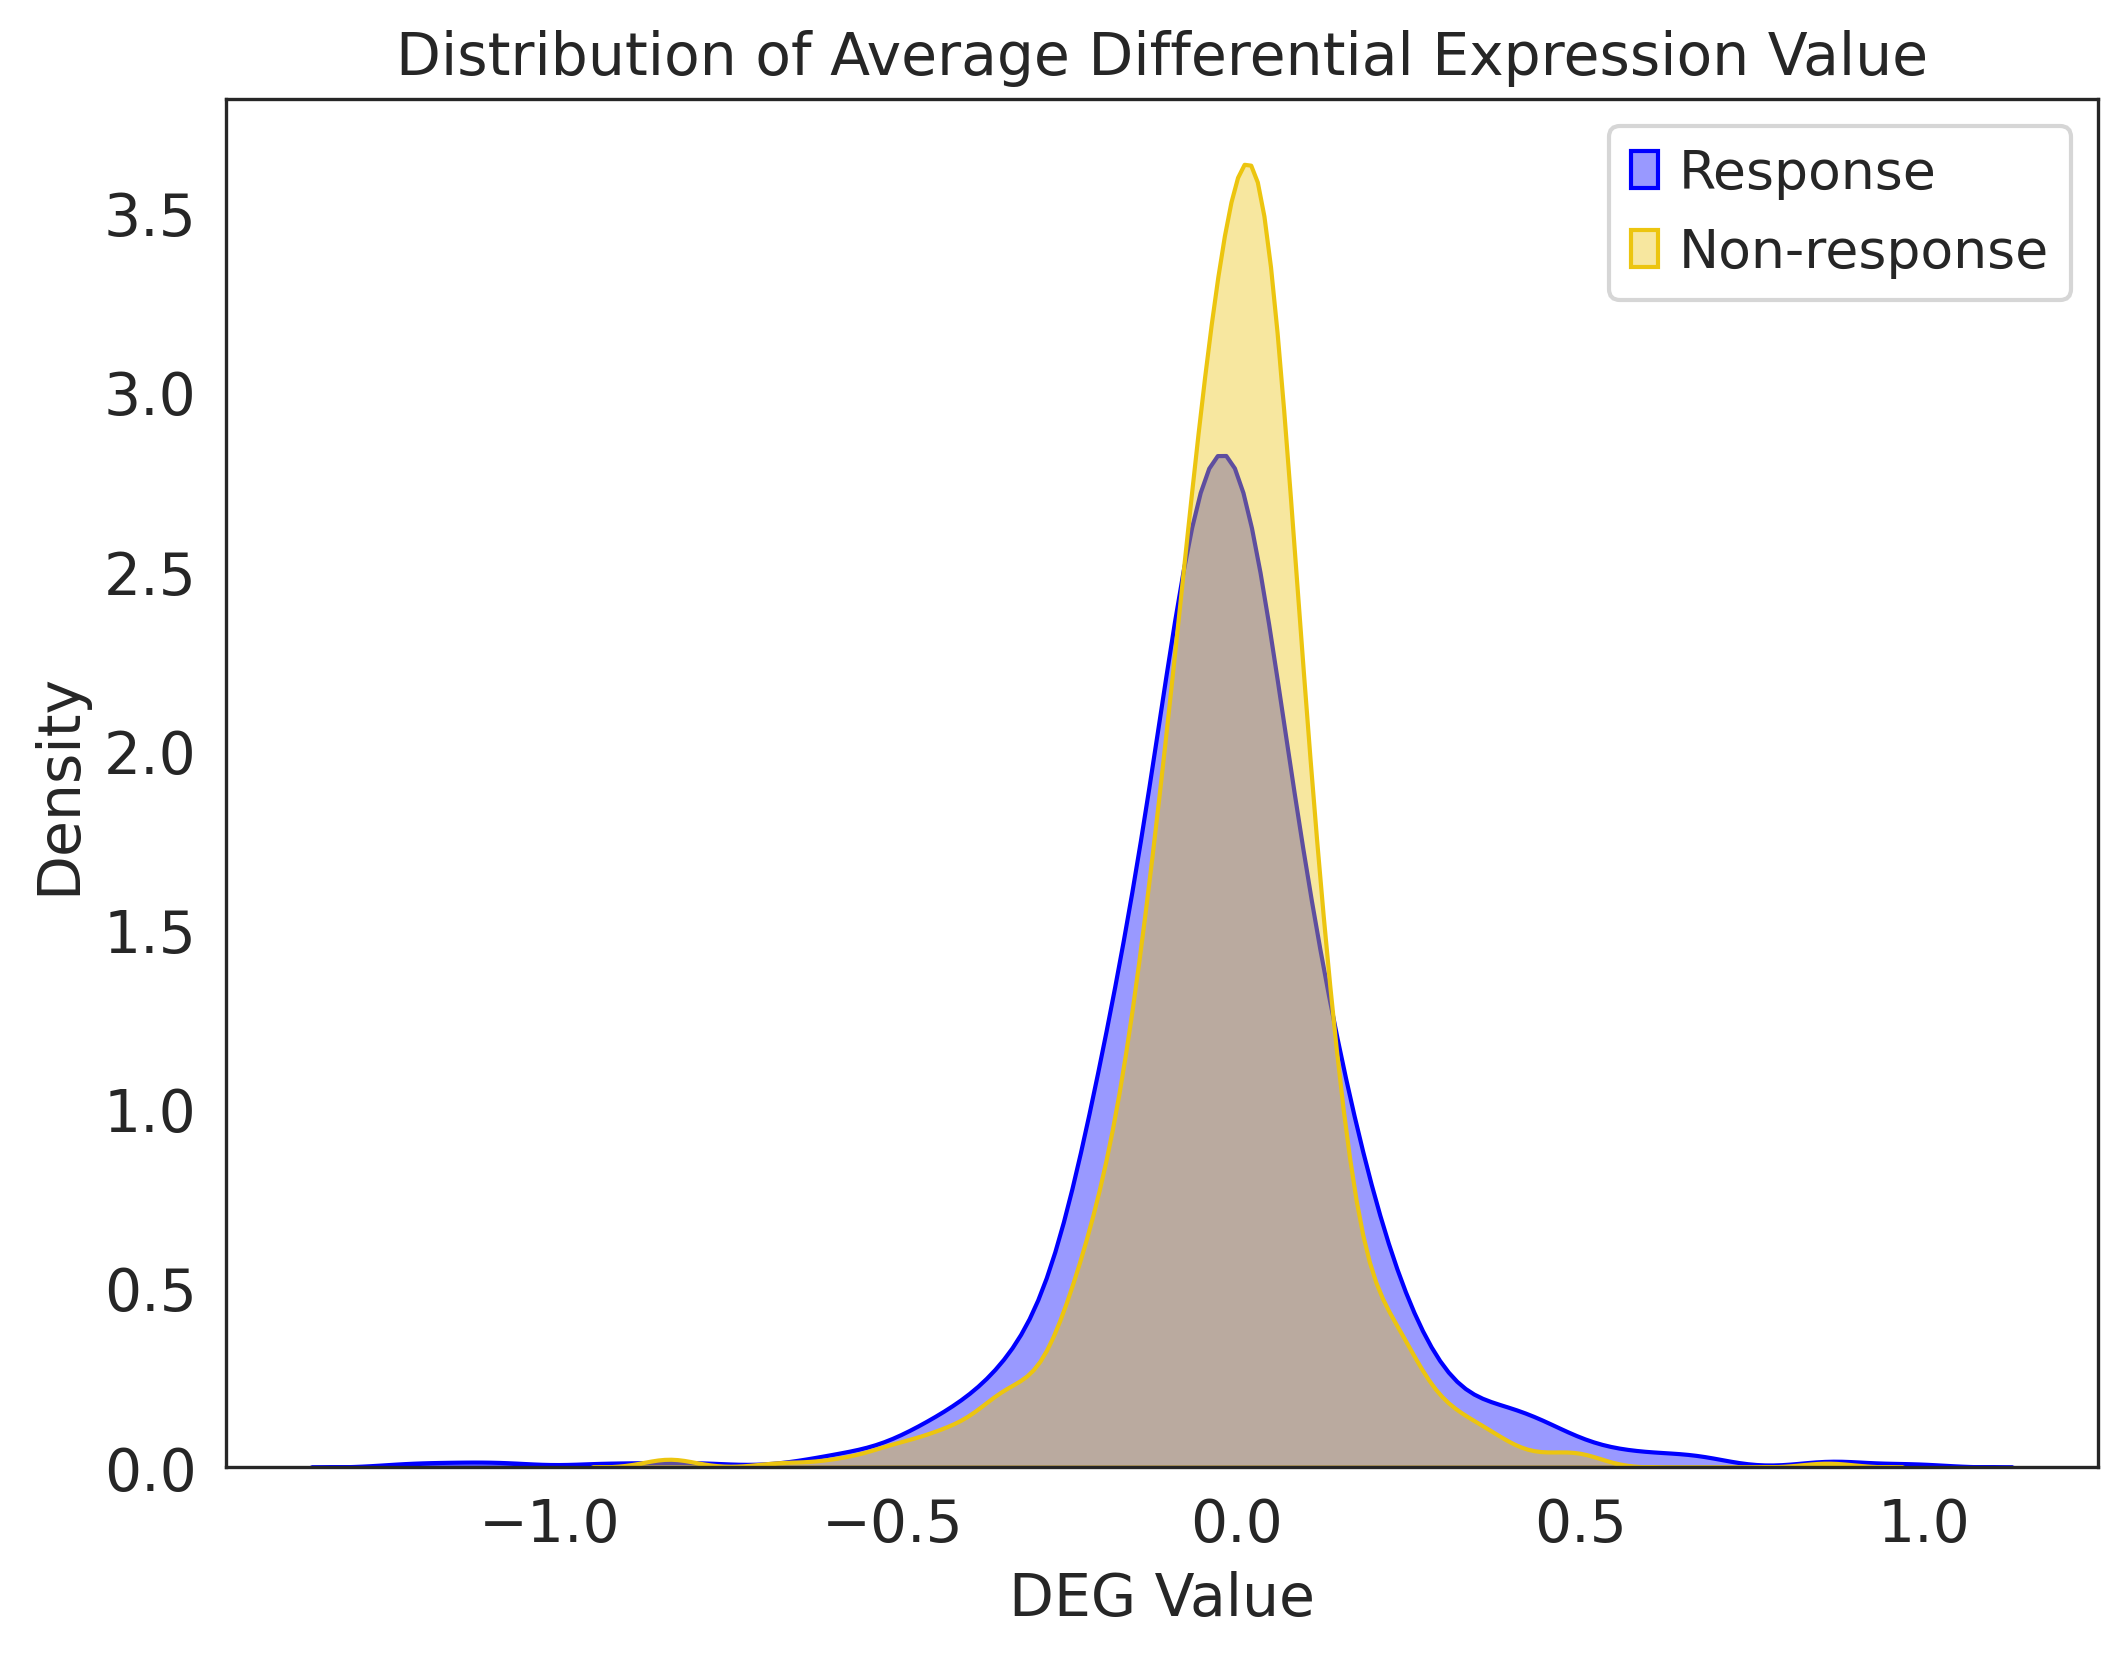

In [23]:
x1 = adata2_breast_deg[adata2_breast_deg.obs["Response group"] == "Response"].X.mean(axis=0)
x2 = adata2_breast_deg[adata2_breast_deg.obs["Response group"] == "Non-response"].X.mean(axis=0)

sns.set_style("white")

plt.figure(figsize=(8, 6))

sns.kdeplot(x1, label="Response", fill=True, alpha=0.4, color="blue")
sns.kdeplot(x2, label="Non-response", fill=True, alpha=0.4, color="#ECC50F")

plt.legend()
plt.title("Distribution of Average Differential Expression Value")
plt.xlabel("DEG Value")
plt.ylabel("Density")


# plt.savefig('figs/deg_distribution_of_non&res.svg',dpi=600,format='svg')

plt.show()

In [27]:
result.to_csv("result.csv")